# Perceptron Model - Complete Implementation & Visualization

## What is a Perceptron?
The **Perceptron** is the simplest type of artificial neural network. It's a single-layer neural network that can learn to classify linearly separable data.

### Key Concepts:
1. **Inputs (x)**: Features of our data
2. **Weights (w)**: Learnable parameters that determine importance of each feature
3. **Bias (b)**: A threshold that shifts the decision boundary
4. **Activation Function**: Determines the output (step function for basic perceptron)

### The Perceptron Algorithm:
```
output = activation(sum(weights * inputs) + bias)
```
If `weighted_sum + bias >= 0`, output = 1 (positive class)  
If `weighted_sum + bias < 0`, output = 0 (negative class)

In [14]:
# ============================================================
# CELL 1: Import Required Libraries
# ============================================================

import numpy as np                    # For numerical computations and array operations
import matplotlib.pyplot as plt       # For creating visualizations
from matplotlib.colors import ListedColormap  # For custom colormaps in plots

# Set random seed for reproducibility
# This ensures we get the same random numbers every time we run the code
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [15]:
# ============================================================
# CELL 2: Define the Perceptron Class
# ============================================================

class Perceptron:
    """
    A simple Perceptron classifier implementation.
    
    The perceptron is a linear binary classifier that learns to separate
    two classes using a linear decision boundary.
    
    Attributes:
        learning_rate (float): Controls how much weights are updated each step
        n_iterations (int): Number of passes over the training data
        weights (ndarray): Weight vector after fitting
        bias (float): Bias term after fitting
        errors_per_epoch (list): Number of misclassifications in each epoch
    """
    
    def __init__(self, learning_rate=0.1, n_iterations=100):
        """
        Initialize the Perceptron.
        
        Parameters:
        -----------
        learning_rate : float (default=0.1)
            The step size for weight updates. 
            - Too high: May overshoot the optimal solution
            - Too low: Learning will be very slow
            
        n_iterations : int (default=100)
            Number of complete passes through the training dataset.
            Also called 'epochs'.
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        
        # These will be set during training
        self.weights = None      # Weight vector
        self.bias = None         # Bias term (also called threshold)
        self.errors_per_epoch = []  # Track errors for visualization
    
    def step_function(self, x):
        """
        The activation function for the perceptron.
        
        This is a simple step function (Heaviside function):
        - Returns 1 if x >= 0
        - Returns 0 if x < 0
        
        Parameters:
        -----------
        x : float or ndarray
            The weighted sum of inputs plus bias
            
        Returns:
        --------
        int : 0 or 1
        """
        return np.where(x >= 0, 1, 0)
    
    def fit(self, X, y):
        """
        Train the perceptron on the given data.
        
        The Perceptron Learning Rule:
        For each training example:
        1. Calculate prediction: y_pred = step(w·x + b)
        2. Calculate error: error = y_true - y_pred
        3. Update weights: w = w + learning_rate * error * x
        4. Update bias: b = b + learning_rate * error
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Training data
        y : ndarray of shape (n_samples,)
            Target labels (0 or 1)
            
        Returns:
        --------
        self : object
            Returns the trained perceptron
        """
        # Get number of samples and features
        n_samples, n_features = X.shape
        
        # Initialize weights to zeros
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Clear error history
        self.errors_per_epoch = []
        
        # Training loop - iterate n_iterations times over the entire dataset
        for epoch in range(self.n_iterations):
            errors = 0  # Count misclassifications in this epoch
            
            # Iterate over each training example
            for xi, yi in zip(X, y):
                # Step 1: Calculate the weighted sum (linear combination)
                linear_output = np.dot(xi, self.weights) + self.bias
                
                # Step 2: Apply activation function to get prediction
                y_predicted = self.step_function(linear_output)
                
                # Step 3: Calculate the update value
                update = self.learning_rate * (yi - y_predicted)
                
                # Step 4: Update weights and bias
                self.weights += update * xi
                self.bias += update
                
                # Count errors
                if update != 0:
                    errors += 1
            
            # Store the error count for this epoch
            self.errors_per_epoch.append(errors)
            
            # Early stopping: if no errors, we've converged!
            if errors == 0:
                print(f"Converged after {epoch + 1} epochs!")
                break
        
        return self
    
    def predict(self, X):
        """Make predictions on new data."""
        linear_output = np.dot(X, self.weights) + self.bias
        return self.step_function(linear_output)
    
    def accuracy(self, X, y):
        """Calculate the accuracy of predictions."""
        predictions = self.predict(X)
        return np.mean(predictions == y)

print("Perceptron class defined successfully!")

Perceptron class defined successfully!


In [16]:
# ============================================================
# CELL 3: Generate Complex Training Data
# ============================================================

def generate_complex_data(n_samples=200, difficulty='hard'):
    """
    Generate more complex linearly separable data.
    
    This creates ELONGATED, ROTATED clusters that are CLOSER TOGETHER,
    making the classification task more challenging for the perceptron.
    
    The data simulates a more realistic scenario where:
    - Clusters have different shapes (elliptical, not circular)
    - Classes are closer to the decision boundary
    - Some points are near the boundary (harder to classify)
    - More samples = more chance of misclassification during training
    
    Parameters:
    -----------
    n_samples : int
        Total number of samples
    difficulty : str
        'easy', 'medium', or 'hard' - controls cluster separation
    """
    n_per_class = n_samples // 2
    
    # ============================================================
    # Set separation based on difficulty
    # Harder = clusters are closer together = more epochs needed
    # ============================================================
    separation = {'easy': 3.0, 'medium': 2.0, 'hard': 1.2}[difficulty]
    
    # ============================================================
    # Create ELONGATED clusters using COVARIANCE MATRICES
    # ============================================================
    # A covariance matrix defines the SHAPE and ORIENTATION of a cluster:
    # - Diagonal elements: variance along each axis (spread)
    # - Off-diagonal elements: correlation (creates tilt/rotation)
    # 
    # Example: [[1, 0], [0, 1]] = circular cluster
    #          [[2, 0], [0, 0.5]] = ellipse stretched along x-axis
    #          [[1, 0.8], [0.8, 1]] = ellipse tilted at 45 degrees
    
    # Class 0: Elongated cluster tilted at ~45 degrees (bottom-left region)
    cov_0 = np.array([
        [0.8, 0.6],   # x1 variance=0.8, covariance with x2=0.6
        [0.6, 0.8]    # This creates a tilted ellipse
    ])
    mean_0 = np.array([-separation/2, -separation/2])
    
    # Class 1: Different shaped ellipse (top-right region)
    cov_1 = np.array([
        [0.6, 0.4],   # Slightly narrower ellipse
        [0.4, 0.9]    # Different tilt angle
    ])
    mean_1 = np.array([separation/2, separation/2])
    
    # ============================================================
    # Generate samples from multivariate normal distributions
    # ============================================================
    # np.random.multivariate_normal draws samples from a Gaussian
    # with the specified mean and covariance matrix
    class_0 = np.random.multivariate_normal(mean_0, cov_0, n_per_class)
    class_1 = np.random.multivariate_normal(mean_1, cov_1, n_per_class)
    
    # ============================================================
    # Add BOUNDARY POINTS (points near the decision boundary)
    # ============================================================
    # These are the hardest points to classify - they sit right
    # near where the two classes meet. This makes training harder
    # and requires more weight updates to converge.
    n_boundary = n_per_class // 8  # 12.5% of points near boundary
    
    # Boundary points for class 0: pushed closer to class 1
    boundary_0 = np.random.randn(n_boundary, 2) * 0.25 + np.array([-0.2, -0.2])
    class_0 = np.vstack([class_0[:-n_boundary], boundary_0])
    
    # Boundary points for class 1: pushed closer to class 0
    boundary_1 = np.random.randn(n_boundary, 2) * 0.25 + np.array([0.2, 0.2])
    class_1 = np.vstack([class_1[:-n_boundary], boundary_1])
    
    # Combine all data
    X = np.vstack([class_0, class_1])
    y = np.array([0] * n_per_class + [1] * n_per_class)
    
    # Shuffle the data (important for SGD-style training!)
    shuffle_idx = np.random.permutation(n_samples)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    return X, y

# ============================================================
# Generate our training data with 'hard' difficulty
# ============================================================
# More samples + closer clusters = harder problem = more epochs
X, y = generate_complex_data(n_samples=200, difficulty='hard')

print(f"Generated {len(X)} samples")
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"\nData ranges:")
print(f"  X1: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}]")
print(f"  X2: [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")

Generated 200 samples
Feature matrix shape: (200, 2)
Labels shape: (200,)
Class distribution: [100 100]

Data ranges:
  X1: [-2.31, 3.08]
  X2: [-2.22, 3.16]


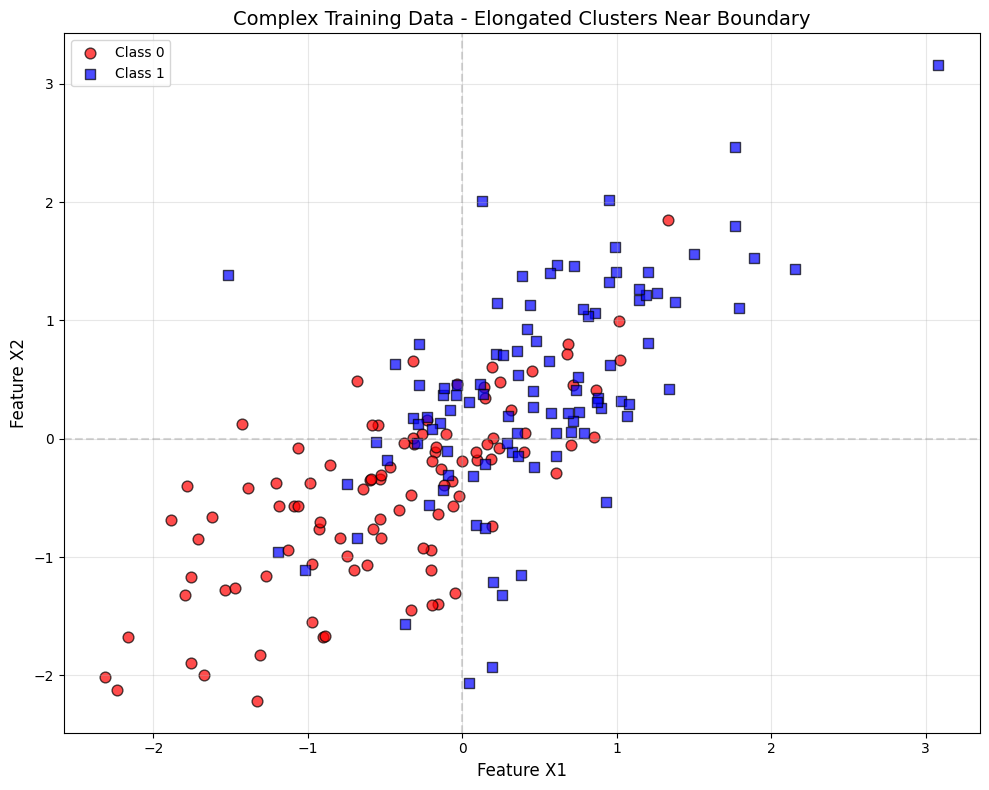

Notice: The clusters are ELONGATED (elliptical) and CLOSE together!
This makes it harder for the perceptron to find the optimal boundary.


In [17]:
# ============================================================
# CELL 4: Visualize the Training Data
# ============================================================

plt.figure(figsize=(10, 8))

# Plot Class 0 (label = 0) in red
plt.scatter(X[y == 0, 0], X[y == 0, 1], 
            c='red', marker='o', s=60, 
            edgecolors='black', alpha=0.7, label='Class 0')

# Plot Class 1 (label = 1) in blue
plt.scatter(X[y == 1, 0], X[y == 1, 1], 
            c='blue', marker='s', s=60, 
            edgecolors='black', alpha=0.7, label='Class 1')

# Highlight the overlapping region
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

plt.xlabel('Feature X1', fontsize=12)
plt.ylabel('Feature X2', fontsize=12)
plt.title('Complex Training Data - Elongated Clusters Near Boundary', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice: The clusters are ELONGATED (elliptical) and CLOSE together!")
print("This makes it harder for the perceptron to find the optimal boundary.")

In [18]:
# ============================================================
# CELL 5: Train the Perceptron
# ============================================================

# Create a Perceptron instance
# Using more iterations since the data is harder to separate
perceptron = Perceptron(learning_rate=0.1, n_iterations=100)

# Train the perceptron on our data
print("Training the Perceptron on complex data...")
print("-" * 50)
perceptron.fit(X, y)

# Display the learned parameters
print("-" * 50)
print(f"Learned weights: w1 = {perceptron.weights[0]:.4f}, w2 = {perceptron.weights[1]:.4f}")
print(f"Learned bias: b = {perceptron.bias:.4f}")
print(f"Final accuracy: {perceptron.accuracy(X, y) * 100:.2f}%")
print(f"Total epochs run: {len(perceptron.errors_per_epoch)}")

Training the Perceptron on complex data...
--------------------------------------------------
--------------------------------------------------
Learned weights: w1 = 0.0568, w2 = 0.1336
Learned bias: b = 0.0000
Final accuracy: 76.00%
Total epochs run: 100


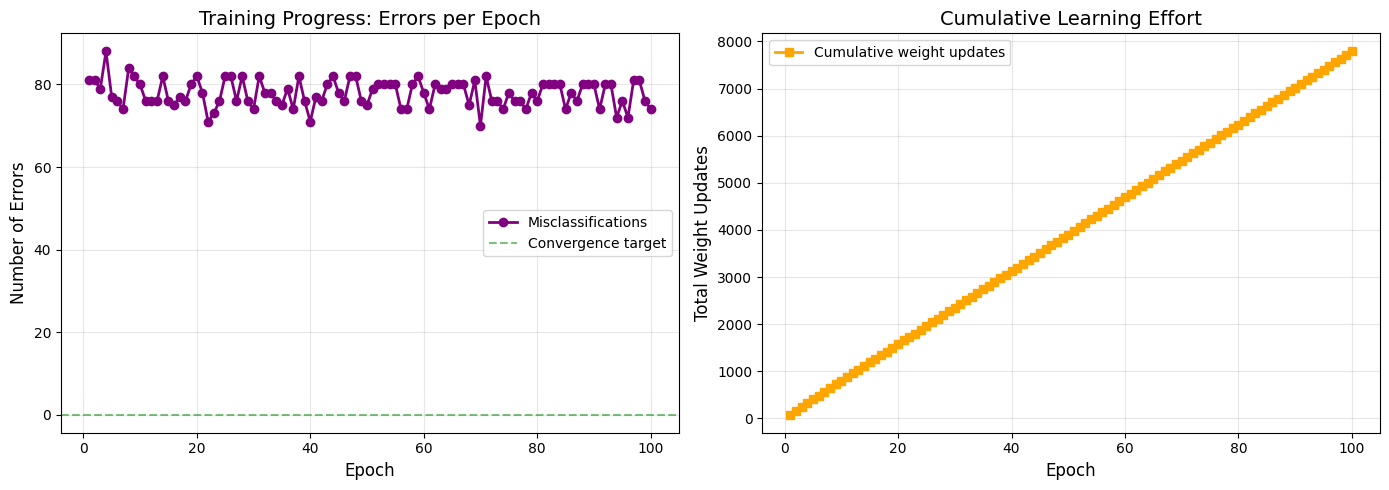

Total weight updates made: 7788
With complex data, convergence takes more epochs than simple data!


In [19]:
# ============================================================
# CELL 6: Visualize Training Progress (Error Convergence)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Errors per epoch
ax1 = axes[0]
epochs = range(1, len(perceptron.errors_per_epoch) + 1)
ax1.plot(epochs, perceptron.errors_per_epoch, 
         marker='o', linewidth=2, markersize=6,
         color='purple', label='Misclassifications')
ax1.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Convergence target')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Number of Errors', fontsize=12)
ax1.set_title('Training Progress: Errors per Epoch', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative errors (total weight updates)
ax2 = axes[1]
cumulative_errors = np.cumsum(perceptron.errors_per_epoch)
ax2.plot(epochs, cumulative_errors, 
         marker='s', linewidth=2, markersize=6,
         color='orange', label='Cumulative weight updates')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Weight Updates', fontsize=12)
ax2.set_title('Cumulative Learning Effort', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total weight updates made: {sum(perceptron.errors_per_epoch)}")
print("With complex data, convergence takes more epochs than simple data!")

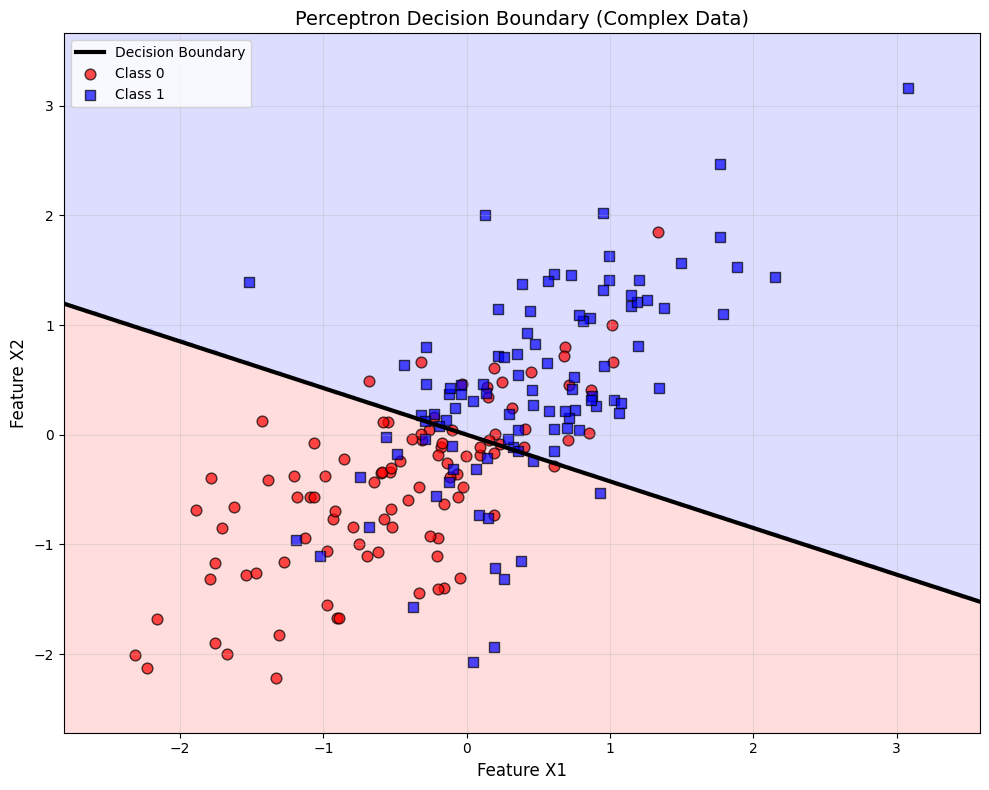

In [20]:
# ============================================================
# CELL 7: Visualize Decision Boundary
# ============================================================

def plot_decision_boundary(X, y, model, title="Decision Boundary"):
    """
    Plot the decision boundary learned by the perceptron.
    
    The decision boundary is where: w1*x1 + w2*x2 + b = 0
    Solving for x2: x2 = -(w1*x1 + b) / w2
    """
    plt.figure(figsize=(10, 8))
    
    # Create a mesh grid for plotting decision regions
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, 200),
        np.linspace(x2_min, x2_max, 200)
    )
    
    # Predict for each point in the mesh
    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    
    # Plot decision regions with colors
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap_light)
    
    # Plot the actual decision boundary line
    w1, w2 = model.weights
    b = model.bias
    x1_line = np.linspace(x1_min, x1_max, 100)
    if w2 != 0:
        x2_line = -(w1 * x1_line + b) / w2
        plt.plot(x1_line, x2_line, 'k-', linewidth=3, label='Decision Boundary')
    
    # Plot the data points
    plt.scatter(X[y == 0, 0], X[y == 0, 1], 
                c='red', marker='o', s=60, 
                edgecolors='black', alpha=0.7, label='Class 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], 
                c='blue', marker='s', s=60, 
                edgecolors='black', alpha=0.7, label='Class 1')
    
    plt.xlabel('Feature X1', fontsize=12)
    plt.ylabel('Feature X2', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='upper left', fontsize=10)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the decision boundary
plot_decision_boundary(X, y, perceptron, 
                       title="Perceptron Decision Boundary (Complex Data)")

COMPARING DIFFICULTY LEVELS
EASY: Converged in 100 epochs, Accuracy: 94.5%
MEDIUM: Converged in 100 epochs, Accuracy: 87.0%
HARD: Converged in 100 epochs, Accuracy: 76.0%


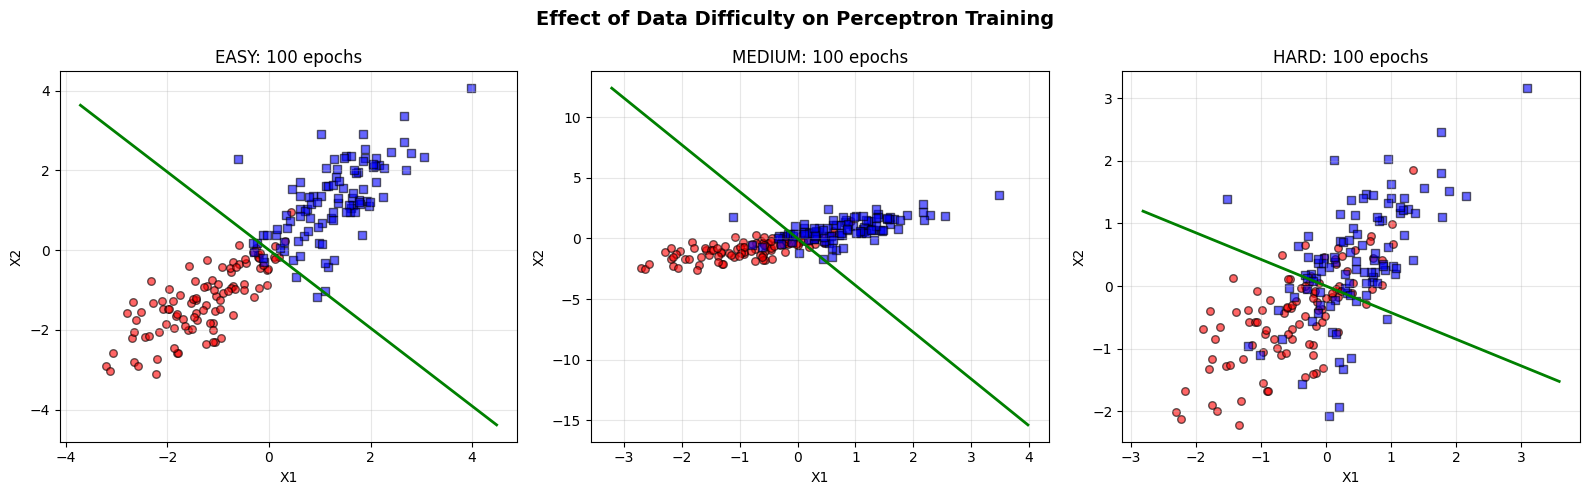

In [21]:
# ============================================================
# CELL 8: Compare Different Difficulty Levels
# ============================================================

print("="*60)
print("COMPARING DIFFICULTY LEVELS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, diff in enumerate(['easy', 'medium', 'hard']):
    # Generate data
    np.random.seed(42)  # Same seed for fair comparison
    X_test, y_test = generate_complex_data(n_samples=200, difficulty=diff)
    
    # Train perceptron
    p = Perceptron(learning_rate=0.1, n_iterations=100)
    p.fit(X_test, y_test)
    
    # Plot
    ax = axes[idx]
    ax.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], 
              c='red', marker='o', s=30, alpha=0.6, edgecolors='black')
    ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], 
              c='blue', marker='s', s=30, alpha=0.6, edgecolors='black')
    
    # Plot decision boundary
    x1_min, x1_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
    x1_line = np.linspace(x1_min, x1_max, 100)
    if p.weights[1] != 0:
        x2_line = -(p.weights[0] * x1_line + p.bias) / p.weights[1]
        ax.plot(x1_line, x2_line, 'g-', linewidth=2)
    
    ax.set_title(f'{diff.upper()}: {len(p.errors_per_epoch)} epochs', fontsize=12)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.grid(True, alpha=0.3)
    
    print(f"{diff.upper()}: Converged in {len(p.errors_per_epoch)} epochs, "
          f"Accuracy: {p.accuracy(X_test, y_test)*100:.1f}%")

plt.suptitle('Effect of Data Difficulty on Perceptron Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [22]:
# ============================================================
# CELL 9: Step-by-Step Prediction Example
# ============================================================

print("="*60)
print("STEP-BY-STEP PREDICTION EXAMPLE")
print("="*60)

# Take a sample point near the boundary
sample_point = np.array([0.1, 0.2])

print(f"\nInput point: x1 = {sample_point[0]}, x2 = {sample_point[1]}")
print(f"\nLearned parameters:")
print(f"  w1 = {perceptron.weights[0]:.4f}")
print(f"  w2 = {perceptron.weights[1]:.4f}")
print(f"  b  = {perceptron.bias:.4f}")

# Step 1: Calculate weighted sum
weighted_sum = (perceptron.weights[0] * sample_point[0] + 
                perceptron.weights[1] * sample_point[1] + 
                perceptron.bias)

print(f"\nStep 1: Calculate weighted sum")
print(f"  z = w1*x1 + w2*x2 + b")
print(f"  z = {perceptron.weights[0]:.4f}*{sample_point[0]} + {perceptron.weights[1]:.4f}*{sample_point[1]} + {perceptron.bias:.4f}")
print(f"  z = {weighted_sum:.4f}")

# Step 2: Apply activation function
prediction = 1 if weighted_sum >= 0 else 0
print(f"\nStep 2: Apply step function")
print(f"  Since z = {weighted_sum:.4f} {'≥' if weighted_sum >= 0 else '<'} 0")
print(f"  Output = {prediction}")
print(f"\n→ The point ({sample_point[0]}, {sample_point[1]}) is classified as Class {prediction}")

STEP-BY-STEP PREDICTION EXAMPLE

Input point: x1 = 0.1, x2 = 0.2

Learned parameters:
  w1 = 0.0568
  w2 = 0.1336
  b  = 0.0000

Step 1: Calculate weighted sum
  z = w1*x1 + w2*x2 + b
  z = 0.0568*0.1 + 0.1336*0.2 + 0.0000
  z = 0.0324

Step 2: Apply step function
  Since z = 0.0324 ≥ 0
  Output = 1

→ The point (0.1, 0.2) is classified as Class 1


In [23]:
# ============================================================
# CELL 10: Visualize Weight Updates During Training
# ============================================================

class PerceptronWithHistory(Perceptron):
    """Extended Perceptron that records weight history for visualization."""
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.errors_per_epoch = []
        
        # Track weight history (record at end of each epoch, not every update)
        self.weight_history = [(self.weights.copy(), self.bias)]
        
        for epoch in range(self.n_iterations):
            errors = 0
            for xi, yi in zip(X, y):
                linear_output = np.dot(xi, self.weights) + self.bias
                y_predicted = self.step_function(linear_output)
                update = self.learning_rate * (yi - y_predicted)
                self.weights += update * xi
                self.bias += update
                if update != 0:
                    errors += 1
            
            self.errors_per_epoch.append(errors)
            # Record weights at end of each epoch
            self.weight_history.append((self.weights.copy(), self.bias))
            
            if errors == 0:
                break
        return self

# Train with history tracking
perceptron_history = PerceptronWithHistory(learning_rate=0.1, n_iterations=100)
perceptron_history.fit(X, y)

print(f"Recorded {len(perceptron_history.weight_history)} weight snapshots (one per epoch)")

Recorded 101 weight snapshots (one per epoch)


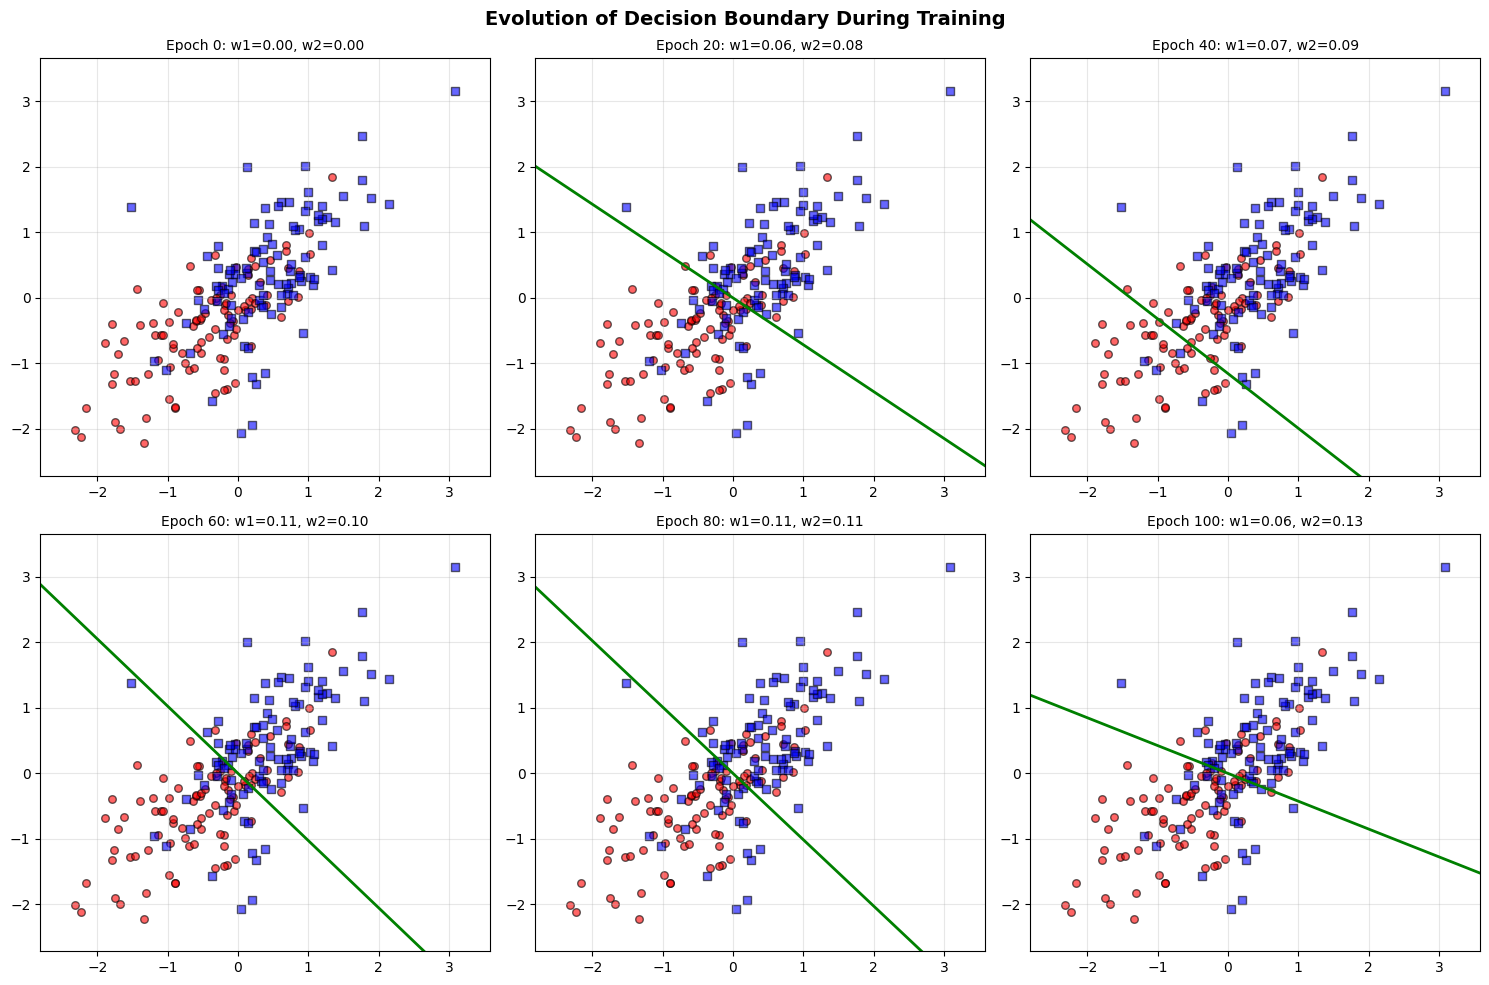

Watch how the boundary rotates and shifts to separate the clusters!


In [24]:
# ============================================================
# CELL 11: Animate Decision Boundary Evolution
# ============================================================

# Select key snapshots to show evolution
n_snapshots = min(6, len(perceptron_history.weight_history))
indices = np.linspace(0, len(perceptron_history.weight_history)-1, n_snapshots, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

for i, idx in enumerate(indices):
    ax = axes[i]
    weights, bias = perceptron_history.weight_history[idx]
    
    # Plot data points
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c='red', marker='o', s=30, edgecolors='black', alpha=0.6)
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', marker='s', s=30, edgecolors='black', alpha=0.6)
    
    # Plot decision boundary
    x1_line = np.linspace(x1_min, x1_max, 100)
    if weights[1] != 0:
        x2_line = -(weights[0] * x1_line + bias) / weights[1]
        ax.plot(x1_line, x2_line, 'g-', linewidth=2)
    
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    ax.set_title(f'Epoch {idx}: w1={weights[0]:.2f}, w2={weights[1]:.2f}', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Evolution of Decision Boundary During Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Watch how the boundary rotates and shifts to separate the clusters!")

In [25]:
# ============================================================
# CELL 12: AND Gate Demo (Classic Perceptron Example)
# ============================================================

print("="*60)
print("CLASSIC EXAMPLE: Learning the AND Gate")
print("="*60)

X_and = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([0, 0, 0, 1])

print("\nAND Gate Truth Table:")
print("X1 | X2 | Y")
print("-" * 12)
for xi, yi in zip(X_and, y_and):
    print(f" {xi[0]} |  {xi[1]} | {yi}")

and_perceptron = Perceptron(learning_rate=0.1, n_iterations=10)
and_perceptron.fit(X_and, y_and)

print(f"\nLearned weights: w1={and_perceptron.weights[0]:.2f}, w2={and_perceptron.weights[1]:.2f}")
print(f"Learned bias: b={and_perceptron.bias:.2f}")

print("\nPredictions:")
for xi, yi in zip(X_and, y_and):
    pred = and_perceptron.predict(xi.reshape(1, -1))[0]
    status = "✓" if pred == yi else "✗"
    print(f"  Input: {xi} → Predicted: {pred}, Actual: {yi} {status}")

CLASSIC EXAMPLE: Learning the AND Gate

AND Gate Truth Table:
X1 | X2 | Y
------------
 0 |  0 | 0
 0 |  1 | 0
 1 |  0 | 0
 1 |  1 | 1
Converged after 4 epochs!

Learned weights: w1=0.20, w2=0.10
Learned bias: b=-0.20

Predictions:
  Input: [0 0] → Predicted: 0, Actual: 0 ✓
  Input: [0 1] → Predicted: 0, Actual: 0 ✓
  Input: [1 0] → Predicted: 0, Actual: 0 ✓
  Input: [1 1] → Predicted: 1, Actual: 1 ✓


In [26]:
# ============================================================
# CELL 13: XOR Problem - Perceptron Limitation
# ============================================================

print("="*60)
print("LIMITATION: XOR Problem (Not Linearly Separable)")
print("="*60)

X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([0, 1, 1, 0])

print("\nXOR Gate Truth Table:")
print("X1 | X2 | Y")
print("-" * 12)
for xi, yi in zip(X_xor, y_xor):
    print(f" {xi[0]} |  {xi[1]} | {yi}")

xor_perceptron = Perceptron(learning_rate=0.1, n_iterations=100)
xor_perceptron.fit(X_xor, y_xor)

print(f"\nAccuracy: {xor_perceptron.accuracy(X_xor, y_xor) * 100:.0f}%")
print("\n⚠ The perceptron CANNOT learn XOR because it's not linearly separable!")
print("This is the fundamental limitation that led to multi-layer networks.")

LIMITATION: XOR Problem (Not Linearly Separable)

XOR Gate Truth Table:
X1 | X2 | Y
------------
 0 |  0 | 0
 0 |  1 | 1
 1 |  0 | 1
 1 |  1 | 0

Accuracy: 50%

⚠ The perceptron CANNOT learn XOR because it's not linearly separable!
This is the fundamental limitation that led to multi-layer networks.


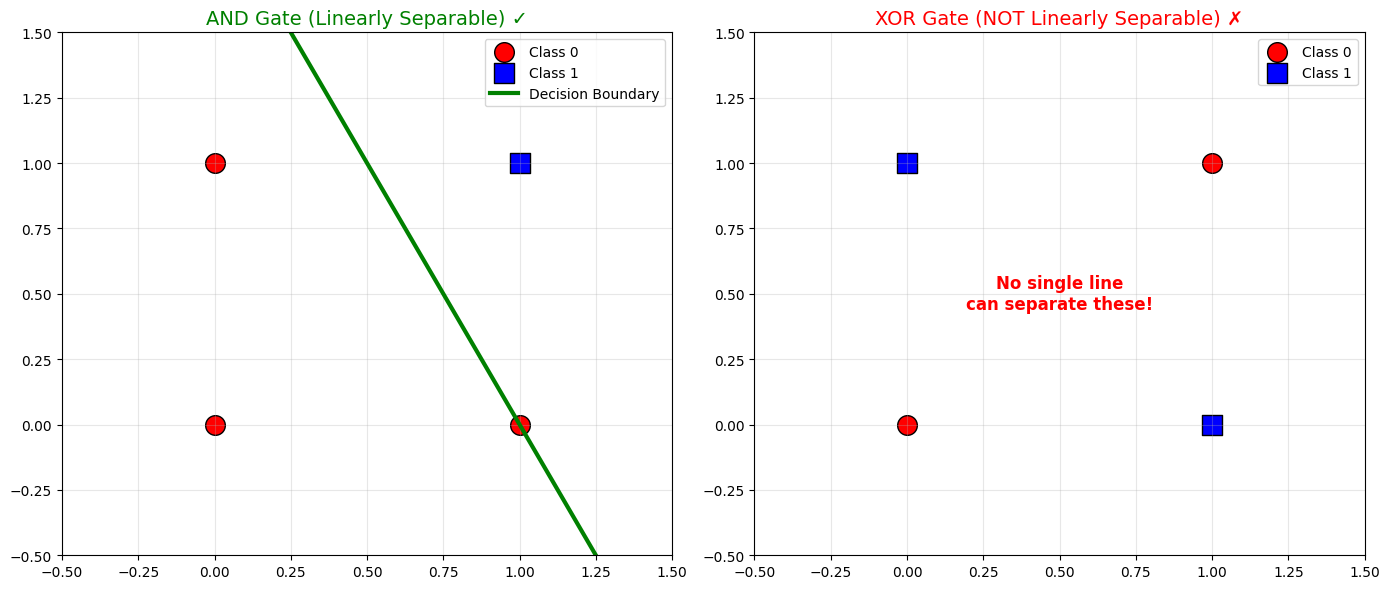

In [27]:
# ============================================================
# CELL 14: Compare AND vs XOR Visualization
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# AND gate
ax1 = axes[0]
ax1.scatter([0, 0, 1], [0, 1, 0], c='red', s=200, marker='o', label='Class 0', edgecolors='black')
ax1.scatter([1], [1], c='blue', s=200, marker='s', label='Class 1', edgecolors='black')
x_line = np.linspace(-0.5, 1.5, 100)
if and_perceptron.weights[1] != 0:
    y_line = -(and_perceptron.weights[0] * x_line + and_perceptron.bias) / and_perceptron.weights[1]
    ax1.plot(x_line, y_line, 'g-', linewidth=3, label='Decision Boundary')
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.5, 1.5)
ax1.set_title('AND Gate (Linearly Separable) ✓', fontsize=14, color='green')
ax1.legend()
ax1.grid(True, alpha=0.3)

# XOR gate
ax2 = axes[1]
ax2.scatter([0, 1], [0, 1], c='red', s=200, marker='o', label='Class 0', edgecolors='black')
ax2.scatter([0, 1], [1, 0], c='blue', s=200, marker='s', label='Class 1', edgecolors='black')
ax2.annotate('No single line\ncan separate these!', xy=(0.5, 0.5), fontsize=12,
             ha='center', va='center', color='red', fontweight='bold')
ax2.set_xlim(-0.5, 1.5)
ax2.set_ylim(-0.5, 1.5)
ax2.set_title('XOR Gate (NOT Linearly Separable) ✗', fontsize=14, color='red')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### What We Learned:

1. **Perceptron Structure**: A simple linear classifier with weights, bias, and step activation

2. **Complex Data**: Real-world data often has:
   - Elongated/elliptical clusters (not perfect circles)
   - Points near the decision boundary
   - Overlapping regions that are still linearly separable

3. **Training Dynamics**: 
   - Harder data = more epochs to converge
   - The boundary rotates and shifts during learning
   - Convergence is guaranteed for linearly separable data

4. **Limitation**: Cannot solve non-linearly separable problems (XOR)

### Next Steps:
- **Multi-Layer Perceptron (MLP)**: Add hidden layers to solve XOR
- **Sigmoid activation**: For smoother gradients
- **Backpropagation**: For training deep networks